In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

In [4]:
def datagen(batch_size, list_of_writers, hshift=(-64,64), vis=False):
    counter = 0
    while True:
        counter = 0
        w_ids, ids = [],[]
        writer_indexes = np.random.randint(0, len(list_of_writers), batch_size)
        x, y, writers = [], [], []
        for writer_index in writer_indexes:
            writer = list_of_writers[writer_index]
            writer_samples = list(images[images['image'].str.match(writer)]['image'])
            
            if len(writer_samples) == 0:
                continue
                
            writer_sample_index = np.random.randint(0,len(writer_samples))
            csv_writer = writer_samples[writer_sample_index][:5]
    
            loaded_image = cv2.imread(os.path.join(image_path, writer_samples[writer_sample_index]), 0)
            rand = np.random.randint(hshift[0],hshift[1])
            loaded_image_shifted=np.roll(axis=0,a=loaded_image,shift=rand)

            x.append(255.0-loaded_image_shifted.reshape((64,64,1)))
            y.append(255.0-loaded_image.reshape((64,64,1)))
            
            w_ids.append(writer[:4])
            writers.append(writer_samples[writer_sample_index])
            ids.append(writer_index)
            
            counter += 1
        
        if counter == batch_size:
            if vis == True:
                yield np.array(x)/255.0, [np.array(w_ids), np.array(ids), np.array(writers)]
            else:
                yield np.array(x)/255.0, np.array(y)/255.0

In [9]:
df_seen = pd.read_csv("seen-dataset/dataset_seen_training_siamese.csv")
del df_seen['Unnamed: 0']

In [17]:
list(set(list(df_seen.right.unique()) + list(df_seen.left.unique())))

['1395a_num3.png',
 '1154a_num6.png',
 '0449b_num6.png',
 '0260c_num1.png',
 '1281c_num2.png',
 '0699a_num5.png',
 '1296b_num7.png',
 '0255b_num1.png',
 '1364a_num3.png',
 '1365a_num1.png',
 '1224c_num3.png',
 '0514c_num3.png',
 '0156a_num3.png',
 '0606a_num4.png',
 '1544c_num2.png',
 '1220b_num1.png',
 '0125a_num3.png',
 '0011a_num7.png',
 '1129b_num5.png',
 '0373b_num2.png',
 '1350b_num2.png',
 '0470b_num2.png',
 '0752b_num4.png',
 '0833c_num1.png',
 '0346a_num4.png',
 '0788b_num1.png',
 '0800c_num3.png',
 '0502b_num4.png',
 '0365a_num4.png',
 '0619b_num1.png',
 '0146c_num1.png',
 '0398a_num1.png',
 '0047b_num1.png',
 '0060c_num2.png',
 '0028a_num1.png',
 '0063a_num4.png',
 '0271b_num4.png',
 '0818b_num6.png',
 '0604c_num1.png',
 '1146b_num4.png',
 '0155c_num5.png',
 '0652a_num1.png',
 '0986c_num2.png',
 '0257c_num1.png',
 '0941c_num2.png',
 '1062aa_num1.png',
 '0882c_num3.png',
 '1482a_num2.png',
 '1111a_num4.png',
 '0448c_num3.png',
 '0065b_num3.png',
 '0658c_num1.png',
 '0992c_num

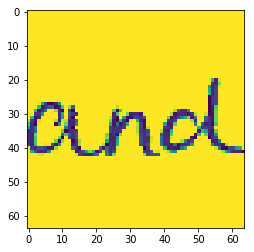

In [26]:
image_path = "seen-dataset/TrainingSet/"
writer_samples = list(set(list(df_seen.right.unique()) + list(df_seen.left.unique())))
writer_sample_index = 5
loaded_image = cv2.imread(os.path.join(image_path, writer_samples[writer_sample_index]), 0)
plt.imshow(loaded_image)

In [27]:
writer_samples[5]

'0699a_num5.png'

In [36]:
df_seen[df_seen.right == writer_samples[5]]

,left,right,label
1751,0699b_num3.png,0699a_num5.png,1
3993,0699c_num2.png,0699a_num5.png,1
58094,0725a_num4.png,0699a_num5.png,0
70928,1173b_num2.png,0699a_num5.png,0
83765,0144a_num1.png,0699a_num5.png,0
96601,1169c_num1.png,0699a_num5.png,0
109432,1469b_num3.png,0699a_num5.png,0


In [30]:
(df_seen.label == 1).sum()

57195

In [33]:
df_seen['label'].count()

114390

In [35]:
(df_seen.label == 0).sum()

57195

## Tensorflow

In [41]:
import tensorflow as tf
from tensorflow import keras
import datetime as dt

tf.enable_eager_execution()

/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [175]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(32).shuffle(10000)
train_dataset = train_dataset.map(lambda x, y: (tf.reshape(tf.div(tf.cast(x, tf.float32), 255.0), (-1, 28, 28, 1)), tf.reshape(tf.one_hot(y, 10), (-1, 10))))
train_dataset = train_dataset.map(lambda x, y: (tf.image.random_flip_left_right(x), y))
train_dataset = train_dataset.repeat()

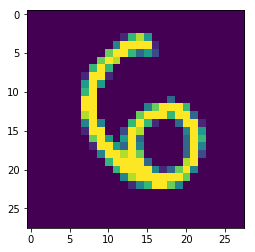

In [186]:
for image, label in train_dataset.take(1):
    pass

image.numpy()[0][:,:,0].shape
plt.imshow(image.numpy()[0][:,:,0])

In [126]:
label[0]

<tf.Tensor: id=16326, shape=(10,), dtype=float32, numpy=array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>

In [187]:
valid_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(1000).shuffle(10000)
valid_dataset = valid_dataset.map(lambda x, y: (tf.reshape(tf.div(tf.cast(x, tf.float32), 255.0), (-1, 28, 28, 1)), tf.reshape(tf.one_hot(y, 10), (-1, 10))))
valid_dataset = valid_dataset.repeat()

In [194]:
class SiameseModel(keras.Model):
    def __init__(self):
        super(SiameseModel, self).__init__(name='siamese')
        # Left
        self.conv_left_1 = keras.layers.Conv2D(64, 5,
                                         padding='same',
                                         activation=tf.nn.relu,
                                         kernel_initializer=tf.initializers.variance_scaling,
                                         kernel_regularizer=keras.regularizers.l2(l=0.001),
                                         input_shape=(28, 28, 1)
                                        )
        self.max_pool2d = keras.layers.MaxPooling2D((3, 3), (2, 2), padding='same')
        self.max_norm = keras.layers.BatchNormalization()
        self.conv_left_2 = keras.layers.Conv2D(64, 5,
                                         padding='same',
                                         activation=tf.nn.relu,
                                         kernel_initializer=tf.initializers.variance_scaling,
                                         kernel_regularizer=keras.regularizers.l2(l=0.001))
        self.flatten = keras.layers.Flatten()
        self.left_neck = keras.layers.Dense(128, activation=tf.nn.relu,
                                      kernel_initializer=tf.initializers.variance_scaling,
                                      kernel_regularizer=keras.regularizers.l2(l=0.001))
        
        # Right
        self.conv_right_1 = keras.layers.Conv2D(64, 5,
                                         padding='same',
                                         activation=tf.nn.relu,
                                         kernel_initializer=tf.initializers.variance_scaling,
                                         kernel_regularizer=keras.regularizers.l2(l=0.001),
                                         input_shape=(28, 28, 1)
                                        )
        self.conv_right_2 = keras.layers.Conv2D(64, 5,
                                         padding='same',
                                         activation=tf.nn.relu,
                                         kernel_initializer=tf.initializers.variance_scaling,
                                         kernel_regularizer=keras.regularizers.l2(l=0.001))
        self.right_neck = keras.layers.Dense(128, activation=tf.nn.relu,
                                      kernel_initializer=tf.initializers.variance_scaling,
                                      kernel_regularizer=keras.regularizers.l2(l=0.001))
        
        # Join
        self.neck = keras.layers.Dense(128, activation=tf.nn.relu,
                                      kernel_initializer=tf.initializers.variance_scaling,
                                      kernel_regularizer=keras.regularizers.l2(l=0.001))
        self.dropout = keras.layers.Dropout(0.5)
        self.logits = keras.layers.Dense(10)
        self.softmax = keras.layers.Softmax()

    def call(self, x):
        # Left
        left = self.max_pool2d(self.conv_left_1(x))
        left = self.max_norm(left)
        left = self.max_pool2d(self.conv_left_2(left))
        left = self.max_norm(left)
        left = self.flatten(left)
        left = self.left_neck(left)
        
        # Left
        right = self.max_pool2d(self.conv_right_1(x))
        right = self.max_norm(right)
        right = self.max_pool2d(self.conv_right_2(right))
        right = self.max_norm(right)
        right = self.flatten(right)
        right = self.right_neck(right)
        
        x = keras.layers.concatenate([left, right])
        x = self.dropout(self.neck(x))
        x = self.logits(x)
        return self.softmax(x)

In [195]:
model = SiameseModel()
model.compile(optimizer=tf.train.AdamOptimizer(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [196]:
model(image)

<tf.Tensor: id=17896, shape=(32, 10), dtype=float32, numpy=
array([[0.10384401, 0.13768125, 0.0711942 , 0.15665165, 0.08833682,
        0.0762419 , 0.07017672, 0.11854258, 0.11339937, 0.06393147],
       [0.0983825 , 0.11137135, 0.07947982, 0.17215104, 0.09641348,
        0.08586176, 0.06685319, 0.13226709, 0.08759758, 0.06962215],
       [0.12138742, 0.12961756, 0.07688332, 0.14448085, 0.1049206 ,
        0.07176102, 0.06104837, 0.13538463, 0.09721287, 0.05730332],
       [0.10699621, 0.15523295, 0.06013263, 0.17208028, 0.08461058,
        0.07097103, 0.05998272, 0.12777674, 0.10298922, 0.05922763],
       [0.10728418, 0.13198295, 0.08120155, 0.17854412, 0.08399055,
        0.08315931, 0.06405196, 0.11415043, 0.09189378, 0.06374113],
       [0.11130143, 0.10389668, 0.08894369, 0.13076222, 0.08966736,
        0.09005065, 0.09021738, 0.11109404, 0.08388563, 0.10018092],
       [0.11807044, 0.1061369 , 0.09227984, 0.11213169, 0.08525728,
        0.08802688, 0.07862905, 0.13796715, 0.0975

In [191]:
model = SiameseModel()
model.compile(optimizer=tf.train.AdamOptimizer(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
callbacks = [
  # Write TensorBoard logs to `./logs` directory
  keras.callbacks.TensorBoard(log_dir='./log/{}'.format(dt.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")))
]
model.fit(train_dataset, epochs=100, steps_per_epoch=1500,
          validation_data=valid_dataset,
          validation_steps=3, callbacks=callbacks)

AttributeError: 'SiameseModel' object has no attribute 'total_loss'

In [58]:
model()

In [68]:
for image, label in train_dataset.take(1):
    pass

In [70]:
label

<tf.Tensor: id=14323, shape=(32, 10), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0